In [1]:
use_cuda_numpy = False
if use_cuda_numpy:
    import numpy as np
    import matplotlib.pyplot as plt
    import cupy as cnp
    import cupyx.scipy as csp
    import cupyx.scipy.linalg as clg
    from time import time
    import os
    
else:
    import numpy as cnp
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy as csp
    import scipy.sparse.linalg as clg
    from time import time
    import os

# 3D Time Dependent Schrödinger Equation

### Routines

In [2]:
#Discretized Hamiltonian as a Sparse Matrix
def cuda_get_discrete_U_L(Nx, Ny, Nz, dx, dy, dz, xs, ys, zs, dt, mx, my, mz, hbar):
    main_diagonal = 1+1j*dt*0.5*hbar*(1/dx**2/mx+1/dy**2/my+1/dz**2/mz)*cnp.ones(Nx*Ny*Nz, dtype=complex_dtype)
    for i in range(Nx):
        for j in range(Ny):
            for k in range(Nz):
                main_diagonal[k*Nx*Ny+j*Nx+i] += 1j*dt*V(xs[i], ys[j], zs[k])/2/hbar
    x_diagonals = -1j*dt*hbar/(4*mx*dx**2)*cnp.ones(Nx*Ny*Nz-1, dtype=complex_dtype)
    y_diagonals = -1j*dt*hbar/(4*my*dy**2)*cnp.ones(Nx*Ny*Nz-Nx, dtype=complex_dtype)
    z_diagonals = -1j*dt*hbar/(4*mz*dz**2)*cnp.ones(Nx*Ny*Nz-Nx*Ny, dtype=complex_dtype)
    # There are some zeros we need to place in these diagonals
    for j in range(Ny*Nz-1):
        x_diagonals[(j+1)*Nx-1] = 0
    for k in range(Nz-1):
        y_diagonals[ (k+1)*Nx*Ny-Nx:(k+1)*Nx*Ny ] = 0
    
    return csp.sparse.diags( diagonals=
        (main_diagonal, x_diagonals, x_diagonals,y_diagonals, y_diagonals, z_diagonals, z_diagonals),
        offsets=cnp.array([0, 1, -1, Nx, -Nx, Nx*Ny, -Nx*Ny]), dtype=complex_dtype,format='csc')

### Simulation Parameters

In [3]:
# name for output directories
exp_name = "3D_test"

# Complex number precision
complex_dtype = cnp.csingle # 64 bit #cnp.cdouble # 128 bit
real_dtype = cnp.single # 32 bit # cnp.double # 64 bit

# hbar, masses
hbar = 1
ms = [1,1,1]

# Time increment
dt = 0.01

# Number of time iterations
numIts = 600

# Number of points to be used per dimension
Ns = [40,40,40] # (Nx, Ny, Nz)
Nx,Ny,Nz = Ns
 
# Output every
outputEvery = 2

# Number of Bohmian Trajectories to Sample and Evolve
numTrajs = 80


# Time grid
ts = np.array([dt*j for j in range(numIts)])

# Intervals for calculating the wave function
xlowers = [-4,-4,-4]
xuppers = [4,4,4]

# Increments to be used per dimension
dxs = [(xuppers[j]-xlowers[j])/(Ns[j]-1) for j in range(3)] # (dx, dy, dz)
dx,dy,dz = dxs

#Create coordinates at which the solution will be calculated
nodes = [np.linspace(xlowers[j], xuppers[j], Ns[j]) for j in range(3)] # (xs, ys, zs)
xs,ys,zs = nodes

print("> Grid Settings:")
print(f"  Using Nx={Ns[0]} Ny={Ns[1]} Nz={Ns[2]} grid points.")
print(f"  Using dx={dxs[0]:.4} dy={dxs[1]:.4} dz={dxs[2]:.4} increments (atomic units)\n")

> Grid Settings:
  Using Nx=40 Ny=40 Nz=40 grid points.
  Using dx=0.2051 dy=0.2051 dz=0.2051 increments (atomic units)



### Scenario

In [4]:
# Potential as a function of position
def V(x,y,z):
    return x**2+y**2+z**2 # Harmonic potential
    #return 0

# Initial Wavefunction
def psi0_gaussian(x,y,z, mus, sigmas, ps, hbar):
    return 1/(sigmas[0]*cnp.sqrt(2*cnp.pi))**0.5*cnp.exp(-(x-mus[0])**2/(4*sigmas[0]**2))*\
            1/(sigmas[1]*cnp.sqrt(2*cnp.pi))**0.5*cnp.exp(-(y-mus[1])**2/(4*sigmas[1]**2))*\
             1/(sigmas[2]*cnp.sqrt(2*cnp.pi))**0.5*cnp.exp(-(z-mus[2])**2/(4*sigmas[2]**2))*\
                cnp.exp(1j*(ps[0]*x+ps[1]*y+ps[2]*z)/hbar)

# parameters for gaussian
mus = [2,-1.5,0]
sigmas = [1.2,0.7,0.4]
ps = [-1.2,0,0]

psi0 = lambda x,y,z: psi0_gaussian(x,y,z, mus=mus, sigmas=sigmas, ps=ps, hbar=hbar)

### Simulation
Prepare Arrays

In [5]:
psi = cnp.zeros(Nx*Ny*Nz, dtype=complex_dtype)

for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            psi[k*Nx*Ny+j*Nx+i] = psi0(nodes[0][i], nodes[1][j], nodes[2][k])

In [6]:
U_L = cuda_get_discrete_U_L(*Ns, *dxs, *nodes, dt, *ms, hbar)
U_R = U_L.conj()
UL_LUdec = clg.splu( U_L )

In [7]:
# initialize Bohmian trajectories
# first get the pdf
#psi0 = cnp.asnumpy(psi)
pdf0 = (psi.conj()*psi).real
pdf0 = pdf0/pdf0.sum() # normalize strictly

# sample randomly
initial_trajs_idx = np.random.choice( pdf0.shape[0], 
            replace=True, size=(numTrajs), p=pdf0 ) #[numTrajs] indices
# need to convert them to positions
k_s = initial_trajs_idx//(Nx*Ny)
rest = initial_trajs_idx%(Nx*Ny)
j_s = rest//Nx
i_s = rest%Nx

# avoiding edges - probability density is zero there
i_s[i_s==0] = 1
i_s[i_s==Ns[0]-1] = Ns[0]-2
j_s[j_s==0] = 1
j_s[j_s==Ns[1]-1] = Ns[1]-2
k_s[k_s==0] = 1
k_s[k_s==Ns[2]-1] = Ns[2]-2

trajs = cnp.zeros((numTrajs, 3))
for tr, (i, j, k) in enumerate(zip(i_s,j_s,k_s)):
    trajs[tr] = [nodes[0][i], nodes[1][j], nodes[2][k]]
    
dxs = cnp.array(dxs)[cnp.newaxis,:]
Ns = cnp.array(Ns)[cnp.newaxis, :]
xlowers = cnp.array(xlowers)[cnp.newaxis, :]
xuppers = cnp.array(xuppers)[cnp.newaxis, :]

Create Directories

In [8]:
os.makedirs(f"./OUTPUTS/{exp_name}/pdf/", exist_ok=True)
os.makedirs(f"./OUTPUTS/{exp_name}/trajs/", exist_ok=True)

Run Iterations

In [9]:
dpsi_dx = cnp.zeros(Ns[0], dtype=complex_dtype)
dpsi_dy = cnp.zeros(Ns[0], dtype=complex_dtype)
dpsi_dz = cnp.zeros(Ns[0], dtype=complex_dtype)
v = cnp.zeros(dpsi_dx.shape+(3, ), dtype=real_dtype) #[3, Nx, Ny, Nz]

for it, t in enumerate(ts):
    print(f"\n > It {it}/{numIts}")
    psi_tensor = psi.reshape(Ns[0,::-1]).swapaxes(0,-1) #[Nx,Ny,Nz]
       
    # OUTPUT #####################################################
    if it%outputEvery == 0:
        # compute the magnitude squared of the wavefunction
        pdf = (psi_tensor.conj()*psi_tensor).real
        # Approximate the norm
        print(f"   Iteration {it} Approx.Norm = {pdf.sum()*dx*dy*dz:.4}")
        
        #pdf = cnp.asnumpy(pdf)
        #trajs_numpy = cnp.asnumpy(trajs)
        trajs_numpy = trajs
        
        np.save(f"./OUTPUTS/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                pdf, allow_pickle=True) #[Nx,Ny,Nz]
        np.save(f"./OUTPUTS/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                trajs_numpy, allow_pickle=True) #[numTrajs, 3]
    
    # BOHMIAN VELOCITY FIELD #####################################
    # first the gradient of the wavefunction at each point
    # X
    # boundaries with simple Euler formula O(dx)
    dpsi_dx[0, :, :] = (psi_tensor[1, :, :]-psi_tensor[0, :, :])/dx
    dpsi_dx[-1, :, :] = (psi_tensor[-1, :, :]-psi_tensor[-2, :, :])/dx
    # next boundaries with centered difference O(dx**2)
    dpsi_dx[1,:,:] = (psi_tensor[2,:,:]-psi_tensor[0,:,:])/(2*dx)
    dpsi_dx[-2,:,:] = (psi_tensor[-1,:,:]-psi_tensor[-3,:,:])/(2*dx)
    # rest with O(dx**4) centered difference
    dpsi_dx[2:-2,:,:] = (-psi_tensor[4:,:,:]+8*psi_tensor[3:-1,:,:]-8*psi_tensor[1:-3,:,:]+psi_tensor[:-4,:,:])/(12*dx)

    # DY
    # boundaries with simple Euler formula O(dx)
    dpsi_dy[:, 0, :] = (psi_tensor[:,1, :]-psi_tensor[:,0, :])/dx
    dpsi_dy[:,-1, :] = (psi_tensor[:,-1, :]-psi_tensor[:,-2, :])/dx
    # next boundaries with centered difference O(dx**2)
    dpsi_dy[:,1,:] = (psi_tensor[:,2,:]-psi_tensor[:,0,:])/(2*dx)
    dpsi_dy[:,-2,:] = (psi_tensor[:,-1,:]-psi_tensor[:,-3,:])/(2*dx)
    # rest with O(dx**4) centered difference
    dpsi_dy[:,2:-2,:] = (-psi_tensor[:,4:,:]+8*psi_tensor[:,3:-1,:]-8*psi_tensor[:,1:-3,:]+psi_tensor[:,:-4,:])/(12*dx)

    # DZ
    # boundaries with simple Euler formula O(dx)
    dpsi_dz[:,:,0] = (psi_tensor[:,:,1]-psi_tensor[:,:,0])/dx
    dpsi_dz[:,:,-1] = (psi_tensor[:,:,-1]-psi_tensor[:,:,-2])/dx
    # next boundaries with centered difference O(dx**2)
    dpsi_dz[:,:,1] = (psi_tensor[:,:,2]-psi_tensor[:,:,0])/(2*dx)
    dpsi_dz[:,:,-2] = (psi_tensor[:,:,-1]-psi_tensor[:,:,-3])/(2*dx)
    # rest with O(dx**4) centered difference
    dpsi_dz[:,:,2:-2] = (-psi_tensor[:,:,4:]+8*psi_tensor[:,:,3:-1]-8*psi_tensor[:,:,1:-3]+psi_tensor[:,:,:-4])/(12*dx)

    # Vx, Vy, Vz
    v[:,:,:,0] = hbar*(dpsi_dx/psi_tensor).imag/ms[0]
    v[:,:,:,1] = hbar*(dpsi_dy/psi_tensor).imag/ms[1]
    v[:,:,:,2] = hbar*(dpsi_dz/psi_tensor).imag/ms[2]      
        
    # NEXT PSI ####################################################
    # compute the next time iteration's wavefunction
    U_Rpsi_prev = U_R@psi # this is the vector b in Ax=b
    psi = UL_LUdec.solve(U_Rpsi_prev)
    
    # NEXT TRAJS ##################################################
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs-xlowers)//dxs).T).astype(cnp.uint) # [3, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,np.newaxis]
    raty_down = ((trajs[:,1]-ys[ trajs_idxs[1] ])/(ys[ trajs_idxs[1]+1 ]-ys[ trajs_idxs[1] ]))[:,np.newaxis]
    ratz_down = ((trajs[:,2]-zs[ trajs_idxs[2] ])/(zs[ trajs_idxs[2]+1 ]-zs[ trajs_idxs[2] ]))[:,np.newaxis]
    # Evolve trajectories using the interpolated velocity field
    trajs = trajs + dt*( 
        ratx_down*raty_down*ratz_down* v[ trajs_idxs[0]+1, trajs_idxs[1]+1, trajs_idxs[2]+1 ] +
        (1-ratx_down)*raty_down*ratz_down* v[ trajs_idxs[0], trajs_idxs[1]+1, trajs_idxs[2]+1 ] +
        ratx_down*(1-raty_down)*ratz_down* v[ trajs_idxs[0]+1, trajs_idxs[1], trajs_idxs[2]+1 ] +
        ratx_down*raty_down*(1-ratz_down)* v[ trajs_idxs[0]+1, trajs_idxs[1]+1, trajs_idxs[2] ] +
        (1-ratx_down)*(1-raty_down)*ratz_down* v[ trajs_idxs[0], trajs_idxs[1], trajs_idxs[2]+1 ] +
        ratx_down*(1-raty_down)*(1-ratz_down)* v[ trajs_idxs[0]+1, trajs_idxs[1], trajs_idxs[2] ] +
        (1-ratx_down)*raty_down*(1-ratz_down)* v[ trajs_idxs[0], trajs_idxs[1]+1, trajs_idxs[2] ] +
        (1-ratx_down)*(1-raty_down)*(1-ratz_down)* v[ trajs_idxs[0], trajs_idxs[1], trajs_idxs[2] ]
    ) #[numTrajs, 3]
    
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    trajs = cnp.where( trajs>xuppers, xuppers-(trajs-xuppers) ,trajs )
    trajs = cnp.where( trajs<xlowers, xlowers+(xlowers-trajs) ,trajs )   



 > It 0/600
   Iteration 0 Approx.Norm = 0.9602

 > It 1/600

 > It 2/600
   Iteration 2 Approx.Norm = 0.9602

 > It 3/600

 > It 4/600
   Iteration 4 Approx.Norm = 0.9602

 > It 5/600

 > It 6/600
   Iteration 6 Approx.Norm = 0.9602

 > It 7/600

 > It 8/600
   Iteration 8 Approx.Norm = 0.9602

 > It 9/600

 > It 10/600
   Iteration 10 Approx.Norm = 0.9602

 > It 11/600

 > It 12/600
   Iteration 12 Approx.Norm = 0.9602

 > It 13/600

 > It 14/600
   Iteration 14 Approx.Norm = 0.9602

 > It 15/600

 > It 16/600
   Iteration 16 Approx.Norm = 0.9602

 > It 17/600

 > It 18/600
   Iteration 18 Approx.Norm = 0.9602

 > It 19/600

 > It 20/600
   Iteration 20 Approx.Norm = 0.9602

 > It 21/600

 > It 22/600
   Iteration 22 Approx.Norm = 0.9602

 > It 23/600

 > It 24/600
   Iteration 24 Approx.Norm = 0.9602

 > It 25/600

 > It 26/600
   Iteration 26 Approx.Norm = 0.9602

 > It 27/600

 > It 28/600
   Iteration 28 Approx.Norm = 0.9602

 > It 29/600

 > It 30/600
   Iteration 30 Approx.Nor


 > It 246/600
   Iteration 246 Approx.Norm = 0.9602

 > It 247/600

 > It 248/600
   Iteration 248 Approx.Norm = 0.9602

 > It 249/600

 > It 250/600
   Iteration 250 Approx.Norm = 0.9602

 > It 251/600

 > It 252/600
   Iteration 252 Approx.Norm = 0.9602

 > It 253/600

 > It 254/600
   Iteration 254 Approx.Norm = 0.9602

 > It 255/600

 > It 256/600
   Iteration 256 Approx.Norm = 0.9602

 > It 257/600

 > It 258/600
   Iteration 258 Approx.Norm = 0.9602

 > It 259/600

 > It 260/600
   Iteration 260 Approx.Norm = 0.9602

 > It 261/600

 > It 262/600
   Iteration 262 Approx.Norm = 0.9602

 > It 263/600

 > It 264/600
   Iteration 264 Approx.Norm = 0.9602

 > It 265/600

 > It 266/600
   Iteration 266 Approx.Norm = 0.9602

 > It 267/600

 > It 268/600
   Iteration 268 Approx.Norm = 0.9602

 > It 269/600

 > It 270/600
   Iteration 270 Approx.Norm = 0.9602

 > It 271/600

 > It 272/600
   Iteration 272 Approx.Norm = 0.9602

 > It 273/600

 > It 274/600
   Iteration 274 Approx.Norm = 0.


 > It 487/600

 > It 488/600
   Iteration 488 Approx.Norm = 0.9602

 > It 489/600

 > It 490/600
   Iteration 490 Approx.Norm = 0.9602

 > It 491/600

 > It 492/600
   Iteration 492 Approx.Norm = 0.9602

 > It 493/600

 > It 494/600
   Iteration 494 Approx.Norm = 0.9602

 > It 495/600

 > It 496/600
   Iteration 496 Approx.Norm = 0.9602

 > It 497/600

 > It 498/600
   Iteration 498 Approx.Norm = 0.9602

 > It 499/600

 > It 500/600
   Iteration 500 Approx.Norm = 0.9602

 > It 501/600

 > It 502/600
   Iteration 502 Approx.Norm = 0.9602

 > It 503/600

 > It 504/600
   Iteration 504 Approx.Norm = 0.9602

 > It 505/600

 > It 506/600
   Iteration 506 Approx.Norm = 0.9602

 > It 507/600

 > It 508/600
   Iteration 508 Approx.Norm = 0.9602

 > It 509/600

 > It 510/600
   Iteration 510 Approx.Norm = 0.9602

 > It 511/600

 > It 512/600
   Iteration 512 Approx.Norm = 0.9602

 > It 513/600

 > It 514/600
   Iteration 514 Approx.Norm = 0.9602

 > It 515/600

 > It 516/600
   Iteration 516 A

Free stuff

In [10]:
#cnp.get_default_memory_pool().free_all_blocks()
#cnp.get_default_pinned_memory_pool().free_all_blocks()

### Animation Generation

Generate png

Using a mesh in the plot of (3, 40, 40, 40)

 > It 0/600

 > It 2/600

 > It 4/600

 > It 6/600

 > It 8/600

 > It 10/600

 > It 12/600

 > It 14/600

 > It 16/600

 > It 18/600

 > It 20/600

 > It 22/600

 > It 24/600

 > It 26/600

 > It 28/600

 > It 30/600

 > It 32/600

 > It 34/600

 > It 36/600

 > It 38/600

 > It 40/600

 > It 42/600

 > It 44/600

 > It 46/600

 > It 48/600

 > It 50/600

 > It 52/600

 > It 54/600

 > It 56/600

 > It 58/600

 > It 60/600

 > It 62/600

 > It 64/600

 > It 66/600

 > It 68/600

 > It 70/600

 > It 72/600

 > It 74/600

 > It 76/600

 > It 78/600

 > It 80/600

 > It 82/600

 > It 84/600

 > It 86/600

 > It 88/600

 > It 90/600

 > It 92/600

 > It 94/600

 > It 96/600

 > It 98/600

 > It 100/600

 > It 102/600

 > It 104/600

 > It 106/600

 > It 108/600

 > It 110/600

 > It 112/600

 > It 114/600

 > It 116/600

 > It 118/600

 > It 120/600

 > It 122/600

 > It 124/600

 > It 126/600

 > It 128/600

 > It 130/600

 > It 132/600

 > It

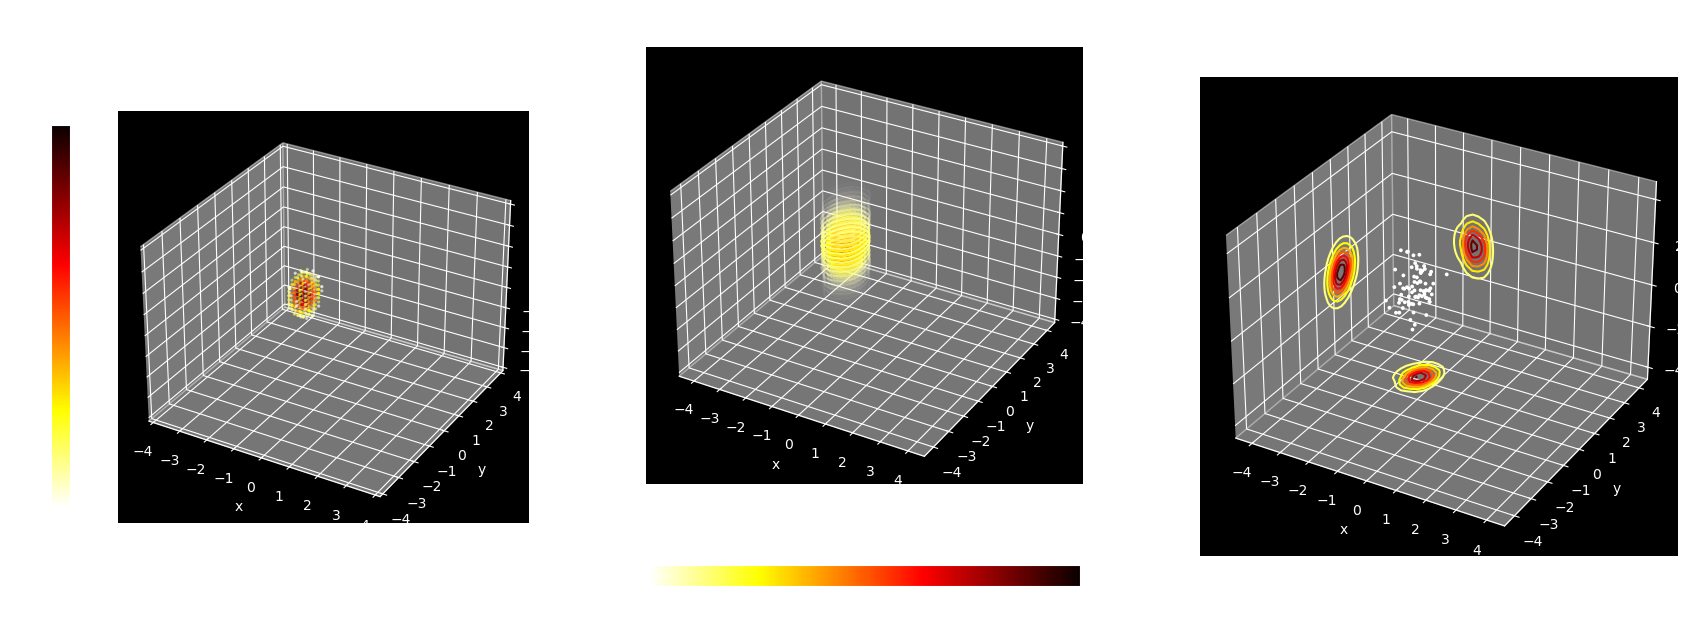

In [11]:
os.makedirs(f"./OUTPUTS/{exp_name}/figs/", exist_ok=True)
image_paths = []
dpi = 100

every=1 # Only take one data point every this number in each axis to plot
grid=np.array(np.meshgrid(*nodes)).swapaxes(1,2)[:,::every, ::every, ::every] #[3,Nx,Ny,Nz]
print(f"Using a mesh in the plot of {grid.shape}")
traj_cs=np.arange(len(trajs))/len(trajs)
fig = plt.figure( figsize=(21,7))

plt.style.use('dark_background')

for it, t in enumerate(ts):
    if it%outputEvery==0:
        print(f"\n > It {it}/{numIts}")
        fig.clf()
        pdf = np.load(f"./OUTPUTS/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        trajs = np.load(f"./OUTPUTS/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        
        ax = fig.add_subplot(131, projection='3d')
        # PDF TRANSP ############################################################
        maxim = pdf.max()
        minim = pdf.min()
        level_surface = grid[:, pdf>maxim/3]
        colormap = ax.scatter(*level_surface, c=pdf[pdf>maxim/3],
                cmap='hot_r', s=2, alpha=pdf[pdf>maxim/3]/maxim ) #, antialiased=True)
        ax.set_xlim((xlowers[0,0], xuppers[0,1]))
        ax.set_ylim((xlowers[0,1], xuppers[0,1]))
        ax.set_zlim((xlowers[0,2], xuppers[0,2]))
        
        fig.colorbar(colormap, fraction=0.04, location='left')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title(f"Probability Density>{maxim/3:.3}\n it={it} t={t:.4}")
        
        # PDF SURFACE LEVELS #####################################################
        ax = fig.add_subplot(132, projection='3d')
        level_surface = grid[:,pdf>maxim/3]
        ax.set_zlim(xlowers[0, -1], xuppers[0,-1])
        for k,z in enumerate(zs):
            cset = ax.contour(grid[0,:,:,0], grid[1,:,:,0], pdf[:,:,k], 
                        7, zdir='z', offset=z, cmap='hot_r', vmin=minim, vmax=maxim,
                             alpha=pdf[:,:,k].max()/maxim)
        ax.set_title(f"Probability Density\n it={it} t={t:.4}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        fig.colorbar(colormap, fraction=0.04, location='bottom', ax=ax)
        
        # PDF + TRAJECTORIES ##############################################
        ax = fig.add_subplot(133, projection='3d')
        #colormap = ax.scatter3D(*grid, c=pdf[ ::every, ::every, ::every],
        #               cmap='hot_r', s=0.1, alpha=0.4 ) #, antialiased=True)
        cset = ax.contour(grid[0,:,:,0], grid[1,:,:,0], pdf.sum(axis=2), 7, zdir='z', offset=xlowers[0,2], cmap='hot_r')
        cset = ax.contour(grid[0,:,0,:], pdf.sum(axis=1), grid[2,:,0,:], 7, zdir='y', offset=xuppers[0,1], cmap='hot_r')
        cset = ax.contour(pdf.sum(axis=0), grid[1,0,:,:], grid[2,0,:,:], 7, zdir='x', offset=xlowers[0,0], cmap='hot_r')
        #fig.colorbar(cset, fraction=0.04, location='left')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title(f"Trajectories and Projected Probability Density Contours\n it={it} t={t:.4}")
        ax.scatter3D(trajs[:,0], trajs[:,1], trajs[:,2], c="white", s=3,
                    alpha=1)
        
        image=f"./OUTPUTS/{exp_name}/figs/it_{it}.png"
        plt.savefig(image, dpi=dpi)
        image_paths.append(image)
        #plt.show()
        


Generate gif

In [12]:
import imageio
fps=7
images_for_animation = [ imageio.v2.imread(image_path) for image_path in image_paths]
imageio.mimsave(f'./OUTPUTS/{exp_name}/CN_TISE_{exp_name}.gif', images_for_animation, duration=fps**-1*len(images_for_animation))

Erase png

In [ ]:
#for image_path in image_paths:
#    os.remove(image_path)